<a href="https://colab.research.google.com/github/Andron00e/CBM_Optim/blob/main/conceptnet_usage_ex.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
'''
download cifar10
dowload in one dir all images from cifa10
preprocess them via CLIP-V
'''

In [1]:
! pip install open_clip_torch
!pip install -U sentence-transformers
!pip install openai-clip
!pip install pytorchcv
!pip install -q git+https://github.com/huggingface/peft.git git+https://github.com/huggingface/transformers.git
!pip install accelerate
!pip install bitsandbytes
!pip install sentencepiece
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 22.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 27.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 32.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 23.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 63.7 MB/s eta 0:00:00
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125925 sha256=dcae89e19cf2a1f8097aeca7bf91935eac9496cf8cf1f58b26c6eb2cd8df1305
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5

In [2]:
import open_clip
from torchvision.datasets import CIFAR10
from open_clip import tokenizer
import torch
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"


In [3]:
open_clip.list_pretrained()

[('RN50', 'openai'),
 ('RN50', 'yfcc15m'),
 ('RN50', 'cc12m'),
 ('RN50-quickgelu', 'openai'),
 ('RN50-quickgelu', 'yfcc15m'),
 ('RN50-quickgelu', 'cc12m'),
 ('RN101', 'openai'),
 ('RN101', 'yfcc15m'),
 ('RN101-quickgelu', 'openai'),
 ('RN101-quickgelu', 'yfcc15m'),
 ('RN50x4', 'openai'),
 ('RN50x16', 'openai'),
 ('RN50x64', 'openai'),
 ('ViT-B-32', 'openai'),
 ('ViT-B-32', 'laion400m_e31'),
 ('ViT-B-32', 'laion400m_e32'),
 ('ViT-B-32', 'laion2b_e16'),
 ('ViT-B-32', 'laion2b_s34b_b79k'),
 ('ViT-B-32', 'datacomp_m_s128m_b4k'),
 ('ViT-B-32', 'commonpool_m_clip_s128m_b4k'),
 ('ViT-B-32', 'commonpool_m_laion_s128m_b4k'),
 ('ViT-B-32', 'commonpool_m_image_s128m_b4k'),
 ('ViT-B-32', 'commonpool_m_text_s128m_b4k'),
 ('ViT-B-32', 'commonpool_m_basic_s128m_b4k'),
 ('ViT-B-32', 'commonpool_m_s128m_b4k'),
 ('ViT-B-32', 'datacomp_s_s13m_b4k'),
 ('ViT-B-32', 'commonpool_s_clip_s13m_b4k'),
 ('ViT-B-32', 'commonpool_s_laion_s13m_b4k'),
 ('ViT-B-32', 'commonpool_s_image_s13m_b4k'),
 ('ViT-B-32', 'commo

In [4]:
clip_model, _, preprocess = open_clip.create_model_and_transforms('ViT-B-16', pretrained='openai')

100%|███████████████████████████████████████| 351M/351M [00:11<00:00, 29.6MiB/s]


In [7]:
clip_model.eval()
context_length = clip_model.context_length
vocab_size = clip_model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in clip_model.parameters()]):,}")
print("Context length:", context_length)
print("Vocab size:", vocab_size)

Model parameters: 149,620,737
Context length: 77
Vocab size: 49408


In [8]:
preprocess

Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=warn)
    CenterCrop(size=(224, 224))
    <function _convert_to_rgb at 0x7e15041af5b0>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)

In [14]:
cifar10 = CIFAR10(os.path.expanduser("~/.cache"), transform=preprocess, download=True)

100%|██████████| 170498071/170498071 [00:05<00:00, 28848735.32it/s]


Extracting /root/.cache/cifar-10-python.tar.gz to /root/.cache


In [17]:
descriptions = {
    "page": "a page of text about segmentation",
    "chelsea": "a facial photo of a tabby cat",
    "astronaut": "a portrait of an astronaut with the American flag",
    "rocket": "a rocket standing on a launchpad",
    "motorcycle_right": "a red motorcycle standing in a garage",
    "camera": "a person looking at a camera on a tripod",
    "horse": "a black-and-white silhouette of a horse",
    "coffee": "a cup of coffee on a saucer",
    "man": "a human of the male sex"
}

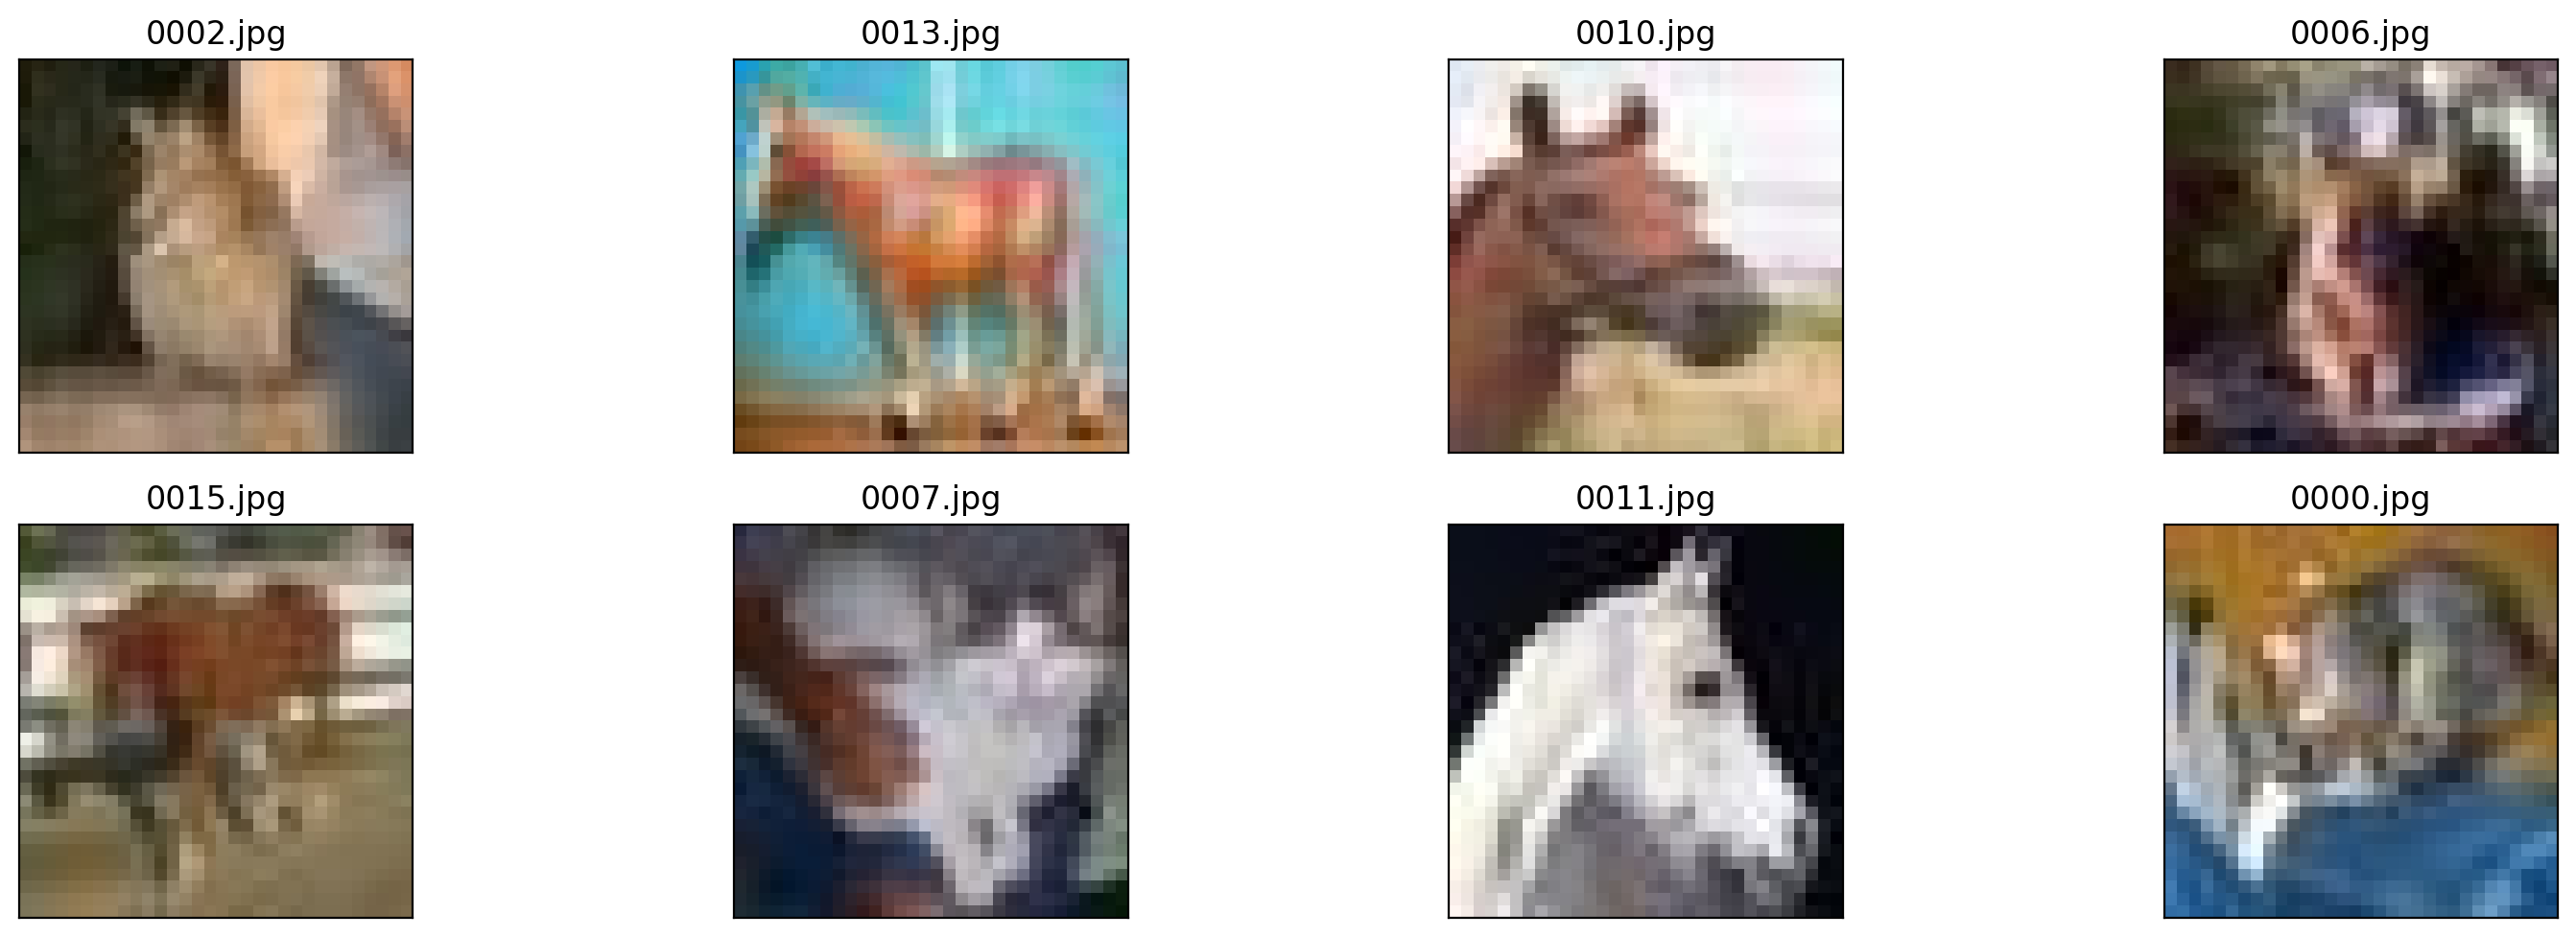

In [20]:
original_images = []
images = []
texts = []
plt.figure(figsize=(16, 5))

for filename in [filename for filename in os.listdir("/content/") if filename.endswith(".png") or filename.endswith(".jpg")]:
    image = Image.open(os.path.join("/content/", filename)).convert("RGB")

    plt.subplot(2, 4, len(images) + 1)
    plt.imshow(image)
    plt.title(f"{filename}")
    plt.xticks([])
    plt.yticks([])

    images.append(preprocess(image))
    original_images.append(image)

plt.tight_layout()

In [32]:
image_input = torch.tensor(np.stack(images))

with torch.no_grad():
    image_features = clip_model.encode_image(image_input).float()

image_features /= image_features.norm(dim=-1, keepdim=True)

In [33]:
text_descriptions = [f"A photo of a {label}" for label in cifar10.classes]
text_tokens = tokenizer.tokenize(text_descriptions)

In [34]:
with torch.no_grad():
    text_features = clip_model.encode_text(text_tokens).float()
    text_features /= text_features.norm(dim=-1, keepdim=True)

text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)
top_probs, top_labels = text_probs.cpu().topk(5, dim=-1)

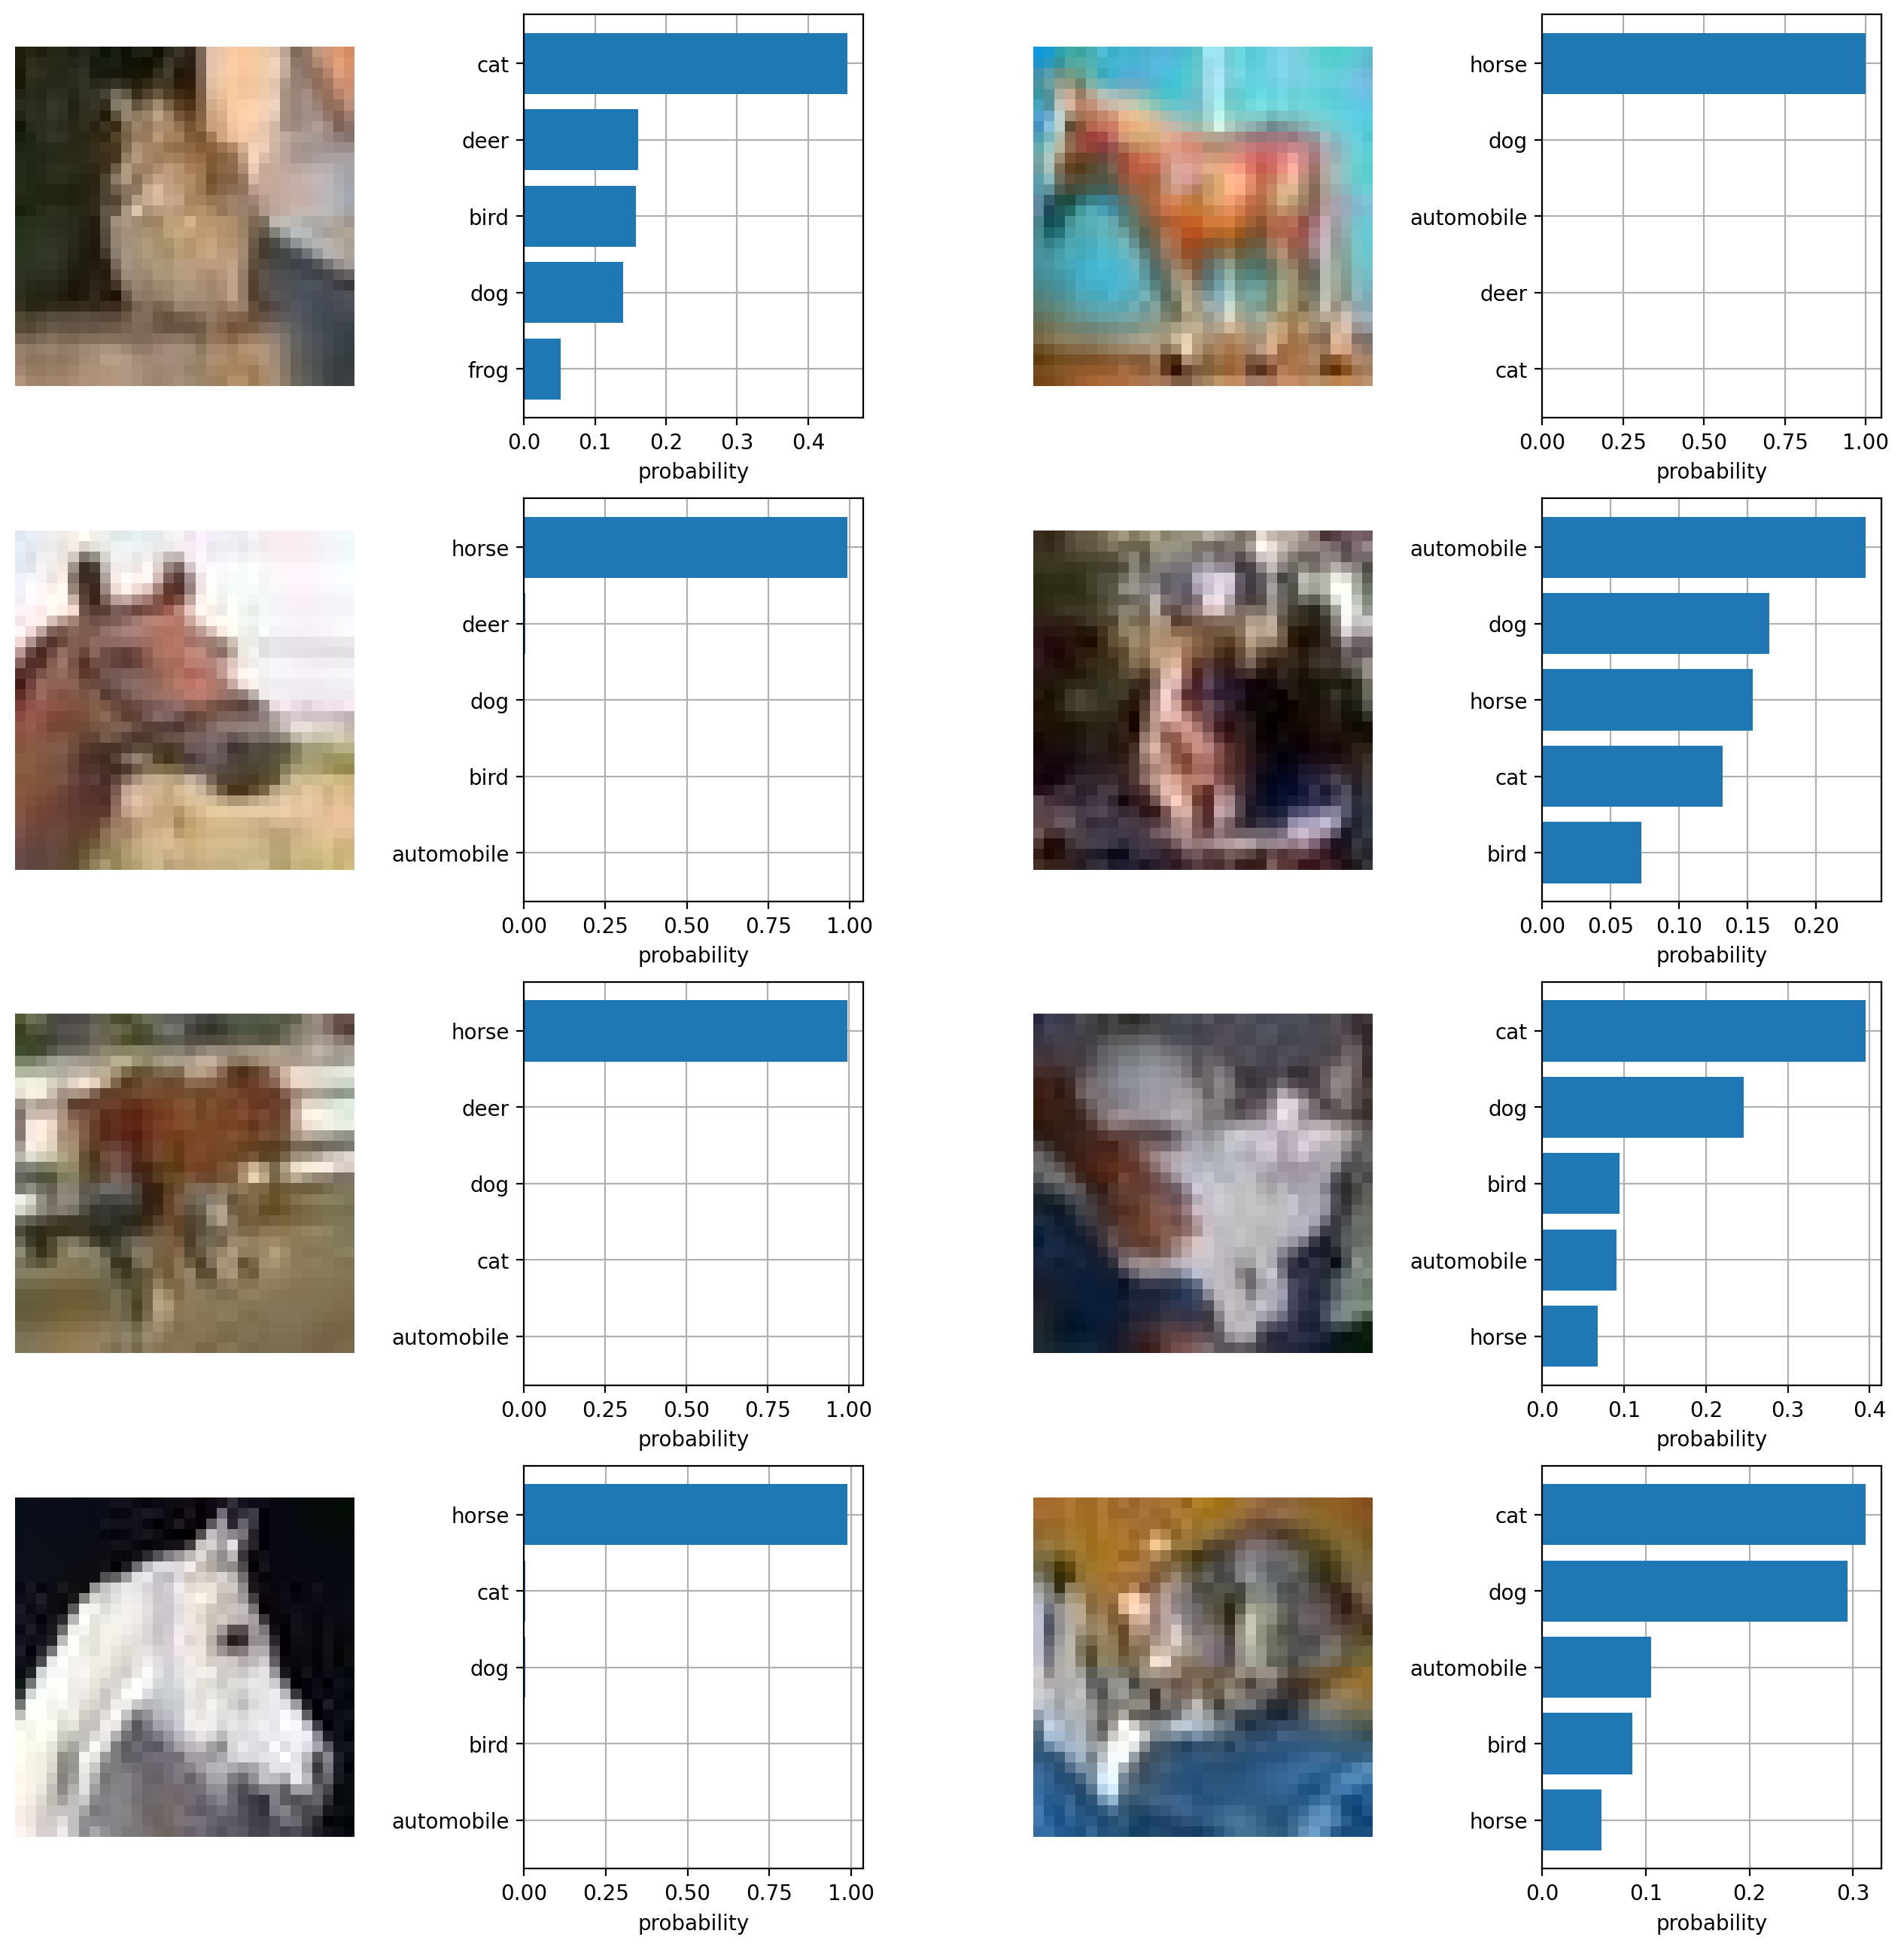

In [35]:
plt.figure(figsize=(16, 16))

for i, image in enumerate(original_images):
    plt.subplot(4, 4, 2 * i + 1)
    plt.imshow(image)
    plt.axis("off")

    plt.subplot(4, 4, 2 * i + 2)
    y = np.arange(top_probs.shape[-1])
    plt.grid()
    plt.barh(y, top_probs[i])
    plt.gca().invert_yaxis()
    plt.gca().set_axisbelow(True)
    plt.yticks(y, [cifar10.classes[index] for index in top_labels[i].numpy()])
    plt.xlabel("probability")

plt.subplots_adjust(wspace=0.5)
plt.show()


# put here concept net features instead of cifar10.classes[index] ...

In [39]:
text_descriptions_2 = []

with open("conceptnet_cifar10_filtered_new.txt", "r") as file:
    for line in file:
        text_descriptions_2.append(line.strip())

print(text_descriptions_2)

['A trunk', 'French person', 'The tail', 'a bigger type of car', 'a bow and a stern', 'a clutch', 'a curious observer of mankind', 'a drive train', 'a form of transportation', 'a good friend', 'a heater', 'a large machine with wings', 'a mans best friend', 'a nose', 'a radiator', 'a tire', 'a vehicle type', 'a vehicle with seats inside it', 'accelerator', 'adornment', 'air sac', 'amphibian', 'an animal', 'an antler', 'an engine', 'an oil pan', 'bay', 'beak', 'bigger than a car', 'bilge pump', 'bilge well', "bird's foot", 'black', 'bulkhead', 'bulwarks', 'bumper', 'cargo area', 'chap', "crow's nest", 'dark meat', 'davit', 'deck', 'domestic animal', 'emergency brakes', 'encolure', 'escape hatch', 'exhaust pipe', 'feather', 'fin', 'flag', 'fleas', 'forecastle', 'four legs', 'fun', 'funnel', 'furcula', 'fuselage', 'galley', 'gaskin', 'giblet', 'gossip', 'green', 'gymnastic apparatus', 'gyrostabilizer', 'hair', 'heavier than air', 'heavier-than-air craft', 'helm', 'hindquarters', 'hood', "h

In [41]:
text_tokens_2 = tokenizer.tokenize(text_descriptions_2)

with torch.no_grad():
    text_features_2 = clip_model.encode_text(text_tokens_2).float()
    text_features_2 /= text_features_2.norm(dim=-1, keepdim=True)

text_probs_2 = (100.0 * image_features @ text_features_2.T).softmax(dim=-1)
top_probs_2, top_labels_2 = text_probs_2.cpu().topk(5, dim=-1)

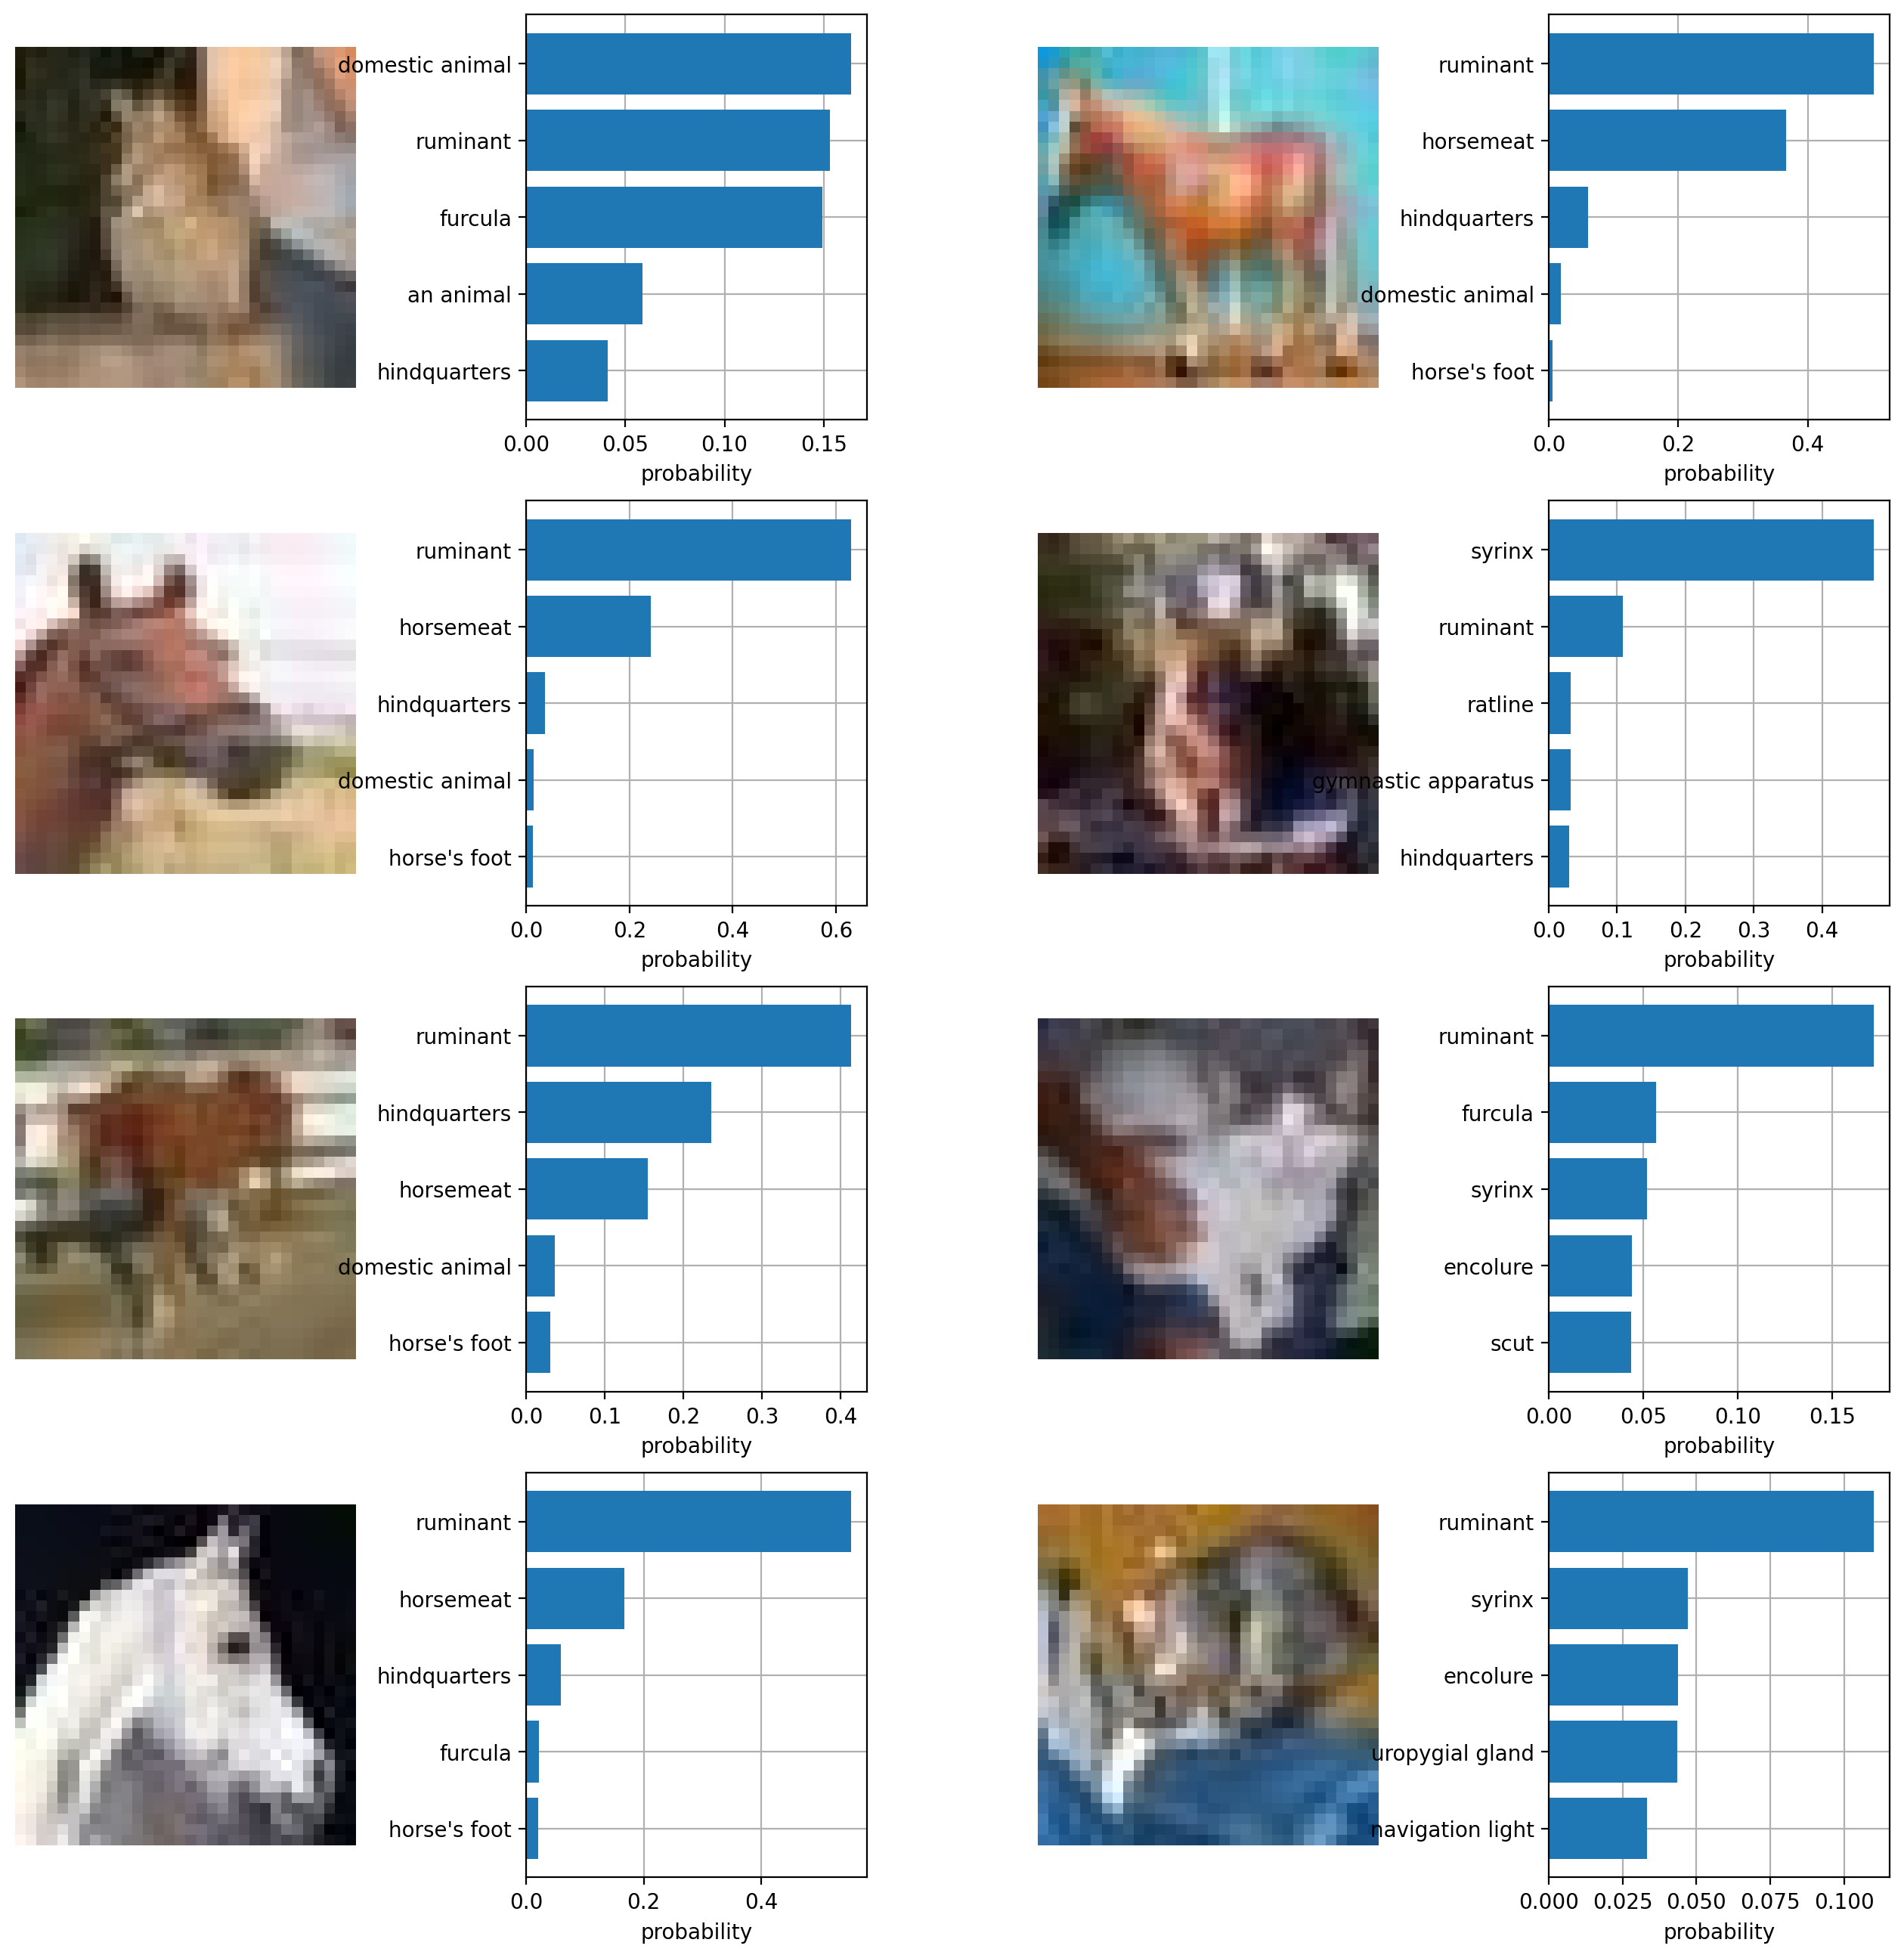

In [42]:
plt.figure(figsize=(16, 16))

for i, image in enumerate(original_images):
    plt.subplot(4, 4, 2 * i + 1)
    plt.imshow(image)
    plt.axis("off")

    plt.subplot(4, 4, 2 * i + 2)
    y = np.arange(top_probs_2.shape[-1])
    plt.grid()
    plt.barh(y, top_probs_2[i])
    plt.gca().invert_yaxis()
    plt.gca().set_axisbelow(True)
    plt.yticks(y, [text_descriptions_2[index] for index in top_labels_2[i].numpy()])
    plt.xlabel("probability")

plt.subplots_adjust(wspace=0.5)
plt.show()